In [ ]:
!pip install pybaseball

In [ ]:
import pandas as pd
import pybaseball as pb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import sklearn as sk
import lightgbm as lgb

In [ ]:
player_df = pb.playerid_lookup("kershaw", "clayton")
player = player_df['key_mlbam'][0]

Gathering player lookup table. This may take a moment.


In [ ]:
data0 = pb.statcast_pitcher('2010-09-08','2021-09-09', player)

Gathering Player Data


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (87,88) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (43) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


In [ ]:
display(data0)

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,...,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
0,FF,2016-06-26,94.6,0.76,6.29,"Kershaw, Clayton",570256,477132,strikeout,swinging_strike,NaN,NaN,NaN,NaN,5.0,Gregory Polanco strikes out swinging.,R,L,L,PIT,LAD,S,2.0,NaN,0,2,2016,0.08,2.02,-0.14,2.76,NaN,455755.0,446481.0,2,6,Bot,NaN,NaN,NaN,...,NaN,NaN,NaN,94.5,2283.0,6.6,447995,477132,518735.0,475100.0,400284.0,457759.0,608369.0,435062.0,592626.0,624577.0,50.0,NaN,NaN,0.0,1.0,0.0,0.0,NaN,53,4,4-Seam Fastball,4,3,4,3,3,4,4,3,Standard,Standard,176.0,-0.040,-0.253
1,SL,2016-06-26,90.5,0.74,6.33,"Kershaw, Clayton",570256,477132,NaN,foul,NaN,NaN,NaN,NaN,13.0,Gregory Polanco strikes out swinging.,R,L,L,PIT,LAD,S,NaN,NaN,0,2,2016,-0.38,0.92,-1.09,1.76,NaN,455755.0,446481.0,2,6,Bot,NaN,NaN,NaN,...,160.0,65.7,20.0,90.2,2476.0,6.1,447995,477132,518735.0,475100.0,400284.0,457759.0,608369.0,435062.0,592626.0,624577.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,3,Slider,4,3,4,3,3,4,4,3,Standard,Standard,206.0,0.000,0.000
2,SL,2016-06-26,90.9,0.74,6.30,"Kershaw, Clayton",570256,477132,NaN,foul,NaN,NaN,NaN,NaN,13.0,Gregory Polanco strikes out swinging.,R,L,L,PIT,LAD,S,NaN,NaN,0,1,2016,-0.26,0.92,-1.23,1.38,NaN,455755.0,446481.0,2,6,Bot,NaN,NaN,NaN,...,2.0,57.3,-40.0,90.2,2477.0,6.3,447995,477132,518735.0,475100.0,400284.0,457759.0,608369.0,435062.0,592626.0,624577.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,2,Slider,4,3,4,3,3,4,4,3,Standard,Standard,201.0,0.000,-0.107
3,FF,2016-06-26,93.6,0.71,6.22,"Kershaw, Clayton",570256,477132,NaN,called_strike,NaN,NaN,NaN,NaN,13.0,Gregory Polanco strikes out swinging.,R,L,L,PIT,LAD,S,NaN,NaN,0,0,2016,0.26,1.95,-0.43,1.42,NaN,455755.0,446481.0,2,6,Bot,NaN,NaN,NaN,...,NaN,NaN,NaN,92.9,2325.0,6.3,447995,477132,518735.0,475100.0,400284.0,457759.0,608369.0,435062.0,592626.0,624577.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,1,4-Seam Fastball,4,3,4,3,3,4,4,3,Standard,Standard,173.0,0.000,-0.065
4,NaN,2016-06-26,NaN,NaN,NaN,"Kershaw, Clayton",446481,477132,intent_walk,intent_ball,NaN,NaN,NaN,NaN,NaN,Clayton Kershaw intentionally walks Sean Rodri...,R,R,L,PIT,LAD,B,NaN,NaN,3,0,2016,NaN,NaN,NaN,NaN,NaN,455755.0,NaN,2,6,Bot,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,447995,477132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,52,4,NaN,4,3,4,3,3,4,4,3,NaN,NaN,NaN,0.007,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12267,FF,2016-09-09,94.0,1.05,6.19,"Kershaw, Clayton",592663,477132,NaN,ball,NaN,NaN,NaN,NaN,13.0,J.T. Realmuto homers (10) on a line drive to l...,R,R,L,MIA,LAD,B,NaN,NaN,1,1,2016,0.28,2.09,-1.09,2.02,NaN,NaN,NaN,1,1,Bot,NaN,NaN,NaN,...,NaN,NaN,NaN,93.5,2440.0,6.3,448968,477132,518735.0,408236.0,400284.0,457759.0,608369.0,592808.0,592626.0,502210.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,3,4-Seam Fastball,0,0,0,0,0,0,0,0,Standard,Standard,177.0,0.000,0.037
12268,CU,2016-09-09,75.4,0.81,

In [ ]:
data1 = data0.dropna(axis='columns', how ='all')
display(data1)

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,fielder_2,sv_id,vx0,vy0,vz0,...,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp
0,FF,2016-06-26,94.6,0.76,6.29,"Kershaw, Clayton",570256,477132,strikeout,swinging_strike,5.0,Gregory Polanco strikes out swinging.,R,L,L,PIT,LAD,S,2.0,NaN,0,2,2016,0.08,2.02,-0.14,2.76,NaN,455755.0,446481.0,2,6,Bot,NaN,NaN,518735.0,160626_221213,-2.96,-137.41,-8.06,...,NaN,NaN,NaN,94.5,2283.0,6.6,447995,477132,518735.0,475100.0,400284.0,457759.0,608369.0,435062.0,592626.0,624577.0,50.0,NaN,NaN,0.0,1.0,0.0,0.0,NaN,53,4,4-Seam Fastball,4,3,4,3,3,4,4,3,Standard,Standard,176.0,-0.040,-0.253
1,SL,2016-06-26,90.5,0.74,6.33,"Kershaw, Clayton",570256,477132,NaN,foul,13.0,Gregory Polanco strikes out swinging.,R,L,L,PIT,LAD,S,NaN,NaN,0,2,2016,-0.38,0.92,-1.09,1.76,NaN,455755.0,446481.0,2,6,Bot,NaN,NaN,518735.0,160626_221127,-4.16,-131.53,-7.44,...,160.0,65.7,20.0,90.2,2476.0,6.1,447995,477132,518735.0,475100.0,400284.0,457759.0,608369.0,435062.0,592626.0,624577.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,3,Slider,4,3,4,3,3,4,4,3,Standard,Standard,206.0,0.000,0.000
2,SL,2016-06-26,90.9,0.74,6.30,"Kershaw, Clayton",570256,477132,NaN,foul,13.0,Gregory Polanco strikes out swinging.,R,L,L,PIT,LAD,S,NaN,NaN,0,1,2016,-0.26,0.92,-1.23,1.38,NaN,455755.0,446481.0,2,6,Bot,NaN,NaN,518735.0,160626_221053,-4.79,-132.05,-8.28,...,2.0,57.3,-40.0,90.2,2477.0,6.3,447995,477132,518735.0,475100.0,400284.0,457759.0,608369.0,435062.0,592626.0,624577.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,2,Slider,4,3,4,3,3,4,4,3,Standard,Standard,201.0,0.000,-0.107
3,FF,2016-06-26,93.6,0.71,6.22,"Kershaw, Clayton",570256,477132,NaN,called_strike,13.0,Gregory Polanco strikes out swinging.,R,L,L,PIT,LAD,S,NaN,NaN,0,0,2016,0.26,1.95,-0.43,1.42,NaN,455755.0,446481.0,2,6,Bot,NaN,NaN,518735.0,160626_221028,-4.03,-135.81,-11.06,...,NaN,NaN,NaN,92.9,2325.0,6.3,447995,477132,518735.0,475100.0,400284.0,457759.0,608369.0,435062.0,592626.0,624577.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,1,4-Seam Fastball,4,3,4,3,3,4,4,3,Standard,Standard,173.0,0.000,-0.065
4,NaN,2016-06-26,NaN,NaN,NaN,"Kershaw, Clayton",446481,477132,intent_walk,intent_ball,NaN,Clayton Kershaw intentionally walks Sean Rodri...,R,R,L,PIT,LAD,B,NaN,NaN,3,0,2016,NaN,NaN,NaN,NaN,NaN,455755.0,NaN,2,6,Bot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,447995,477132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,52,4,NaN,4,3,4,3,3,4,4,3,NaN,NaN,NaN,0.007,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12267,FF,2016-09-09,94.0,1.05,6.19,"Kershaw, Clayton",592663,477132,NaN,ball,13.0,J.T. Realmuto homers (10) on a line drive to l...,R,R,L,MIA,LAD,B,NaN,NaN,1,1,2016,0.28,2.09,-1.09,2.02,NaN,NaN,NaN,1,1,Bot,NaN,NaN,518735.0,160909_192338,-6.73,-136.36,-9.74,...,NaN,NaN,NaN,93.5,2440.0,6.3,448968,477132,518735.0,408236.0,400284.0,457759.0,608369.0,592808.0,592626.0,502210.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,3,4-Seam Fastball,0,0,0,0,0,0,0,0,Standard,Stand

In [ ]:
print(data0.columns)

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estima

In [ ]:
df = data0
df = df.dropna(axis= 'columns', how = 'all')
df = df.loc[(df['plate_x'].notnull()) & (df['plate_z'].notnull())]
df = df.loc[(df['pitch_type'].notnull()) & (df['release_speed'].notnull())]
df['swing'] = 0
df.loc[df['description'].isin(['hit_into_play', 'called_strike', 'swinging_strike', 'swinging_strike_blocked', 
                'foul', 'foul_tip', 'hit_into_play', 'foul_bunt', 
                'missed_bunt']), 'swing'] = 1
display(df)

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,fielder_2,sv_id,vx0,vy0,vz0,...,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,swing
0,FF,2016-06-26,94.6,0.76,6.29,"Kershaw, Clayton",570256,477132,strikeout,swinging_strike,5.0,Gregory Polanco strikes out swinging.,R,L,L,PIT,LAD,S,2.0,NaN,0,2,2016,0.08,2.02,-0.14,2.76,NaN,455755.0,446481.0,2,6,Bot,NaN,NaN,518735.0,160626_221213,-2.96,-137.41,-8.06,...,NaN,NaN,94.5,2283.0,6.6,447995,477132,518735.0,475100.0,400284.0,457759.0,608369.0,435062.0,592626.0,624577.0,50.0,NaN,NaN,0.0,1.0,0.0,0.0,NaN,53,4,4-Seam Fastball,4,3,4,3,3,4,4,3,Standard,Standard,176.0,-0.040,-0.253,1
1,SL,2016-06-26,90.5,0.74,6.33,"Kershaw, Clayton",570256,477132,NaN,foul,13.0,Gregory Polanco strikes out swinging.,R,L,L,PIT,LAD,S,NaN,NaN,0,2,2016,-0.38,0.92,-1.09,1.76,NaN,455755.0,446481.0,2,6,Bot,NaN,NaN,518735.0,160626_221127,-4.16,-131.53,-7.44,...,65.7,20.0,90.2,2476.0,6.1,447995,477132,518735.0,475100.0,400284.0,457759.0,608369.0,435062.0,592626.0,624577.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,3,Slider,4,3,4,3,3,4,4,3,Standard,Standard,206.0,0.000,0.000,1
2,SL,2016-06-26,90.9,0.74,6.30,"Kershaw, Clayton",570256,477132,NaN,foul,13.0,Gregory Polanco strikes out swinging.,R,L,L,PIT,LAD,S,NaN,NaN,0,1,2016,-0.26,0.92,-1.23,1.38,NaN,455755.0,446481.0,2,6,Bot,NaN,NaN,518735.0,160626_221053,-4.79,-132.05,-8.28,...,57.3,-40.0,90.2,2477.0,6.3,447995,477132,518735.0,475100.0,400284.0,457759.0,608369.0,435062.0,592626.0,624577.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,2,Slider,4,3,4,3,3,4,4,3,Standard,Standard,201.0,0.000,-0.107,1
3,FF,2016-06-26,93.6,0.71,6.22,"Kershaw, Clayton",570256,477132,NaN,called_strike,13.0,Gregory Polanco strikes out swinging.,R,L,L,PIT,LAD,S,NaN,NaN,0,0,2016,0.26,1.95,-0.43,1.42,NaN,455755.0,446481.0,2,6,Bot,NaN,NaN,518735.0,160626_221028,-4.03,-135.81,-11.06,...,NaN,NaN,92.9,2325.0,6.3,447995,477132,518735.0,475100.0,400284.0,457759.0,608369.0,435062.0,592626.0,624577.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,1,4-Seam Fastball,4,3,4,3,3,4,4,3,Standard,Standard,173.0,0.000,-0.065,1
5,IN,2016-06-26,55.2,2.03,8.14,"Kershaw, Clayton",446481,477132,NaN,intent_ball,12.0,Clayton Kershaw intentionally walks Sean Rodri...,R,R,L,PIT,LAD,B,NaN,NaN,2,0,2016,0.25,1.42,4.34,5.65,NaN,455755.0,NaN,2,6,Bot,NaN,NaN,518735.0,160626_220825,3.09,-80.24,4.51,...,NaN,NaN,53.6,1450.0,5.1,447995,477132,518735.0,475100.0,400284.0,457759.0,608369.0,435062.0,592626.0,624577.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52,3,Intentional Ball,4,3,4,3,3,4,4,3,Strategic,Standard,173.0,0.000,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12267,FF,2016-09-09,94.0,1.05,6.19,"Kershaw, Clayton",592663,477132,NaN,ball,13.0,J.T. Realmuto homers (10) on a line drive to l...,R,R,L,MIA,LAD,B,NaN,NaN,1,1,2016,0.28,2.09,-1.09,2.02,NaN,NaN,NaN,1,1,Bot,NaN,NaN,518735.0,160909_192338,-6.73,-136.36,-9.74,...,NaN,NaN,93.5,2440.0,6.3,448968,477132,518735.0,408236.0,400284.0,457759.0,608369.0,592808.0,592626.0,502210.0,50.0,NaN,NaN,NaN,Na

In [ ]:
print(df['description'].unique())

['swinging_strike' 'foul' 'called_strike' 'intent_ball' 'hit_into_play'
 'ball' 'blocked_ball' 'swinging_strike_blocked' 'foul_tip' 'foul_bunt'
 'hit_by_pitch' 'missed_bunt' 'bunt_foul_tip']


In [ ]:
query_df = df.copy()
query_df = query_df.iloc[::-1].reset_index(drop = True)
l = []
for i in range(len(query_df)):
    prev_pitch = None
    if query_df['pitch_number'][i] == 1:
        prev_pitch = 'NA'
    else:
        prev_pitch = query_df['pitch_type'][i - 1]
    l.append(prev_pitch)
query_df['prev_pitch_type'] = l
model_cols = ['prev_pitch_type','pitch_type', 'pitch_number', 'plate_x','plate_z','release_speed','p_throws','pfx_x','pfx_z','vx0','vy0','vz0',
        'strikes','balls', 'swing']
query_df = query_df[model_cols]
pitches = ['FF']
query_df = query_df.loc[query_df['pitch_type'].isin(pitches)]
query_df = query_df.iloc[::-1].reset_index(drop = True)
display(query_df)

,prev_pitch_type,pitch_type,pitch_number,plate_x,plate_z,release_speed,p_throws,pfx_x,pfx_z,vx0,vy0,vz0,strikes,balls,swing
0,SL,FF,4,-0.14,2.76,94.6,L,0.08,2.02,-2.96,-137.41,-8.06,2,0,1
1,NA,FF,1,-0.43,1.42,93.6,L,0.26,1.95,-4.03,-135.81,-11.06,0,0,1
2,CU,FF,6,-1.04,2.29,93.7,L,-0.11,1.81,-4.94,-136.11,-8.50,2,3,1
3,CU,FF,4,0.86,0.97,93.6,L,-0.10,2.01,-0.85,-135.80,-11.94,2,1,0
4,NA,FF,1,0.34,4.13,93.3,L,-0.12,1.76,-1.12,-135.87,-4.00,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16337,FF,FF,2,0.41,2.63,93.9,L,0.16,2.03,-2.78,-136.50,-7.85,0,1,1
16338,NA,FF,1,-0.32,4.08,93.9,L,-0.01,2.16,-4.04,-136.62,-4.72,0,0,0
16339,CU,FF,3,-1.09,2.02,94.0,L,0.28,2.09,-6.73,-136.36,-9.74,1,1,0
16340,NA,FF,1,-0.11,3.07,93.9,L,0.13,2.14,-4.14,-136.45,-7.13,0,0,1


In [ ]:
query_df = query_df.drop(columns = ['pitch_type', 'pitch_number'])
model_df = pd.get_dummies(query_df, ['pitches', 'pitch_type'])
dep = model_df['swing'].astype(int)
ind = model_df.drop('swing', axis = 1).values
x_train, x_test, y_train, y_test = train_test_split(ind, dep, test_size = 0.2, random_state = 0)
display(model_df)

,plate_x,plate_z,release_speed,pfx_x,pfx_z,vx0,vy0,vz0,strikes,balls,swing,pitches_CH,pitches_CU,pitches_FF,pitches_FT,pitches_NA,pitches_SL,pitch_type_L
0,-0.14,2.76,94.6,0.08,2.02,-2.96,-137.41,-8.06,2,0,1,0,0,0,0,0,1,1
1,-0.43,1.42,93.6,0.26,1.95,-4.03,-135.81,-11.06,0,0,1,0,0,0,0,1,0,1
2,-1.04,2.29,93.7,-0.11,1.81,-4.94,-136.11,-8.50,2,3,1,0,1,0,0,0,0,1
3,0.86,0.97,93.6,-0.10,2.01,-0.85,-135.80,-11.94,2,1,0,0,1,0,0,0,0,1
4,0.34,4.13,93.3,-0.12,1.76,-1.12,-135.87,-4.00,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16337,0.41,2.63,93.9,0.16,2.03,-2.78,-136.50,-7.85,0,1,1,0,0,1,0,0,0,1
16338,-0.32,4.08,93.9,-0.01,2.16,-4.04,-136.62,-4.72,0,0,0,0,0,0,0,1,0,1
16339,-1.09,2.02,94.0,0.28,2.09,-6.73,-136.36,-9.74,1,1,0,0,1,0,0,0,0,1
16340,-0.11,3.07,93.9,0.13,2.14,-4.14,-136.45,-7.13,0,0,1,0,0,0,0,1,0,1


In [ ]:
lgbm = lgb.LGBMClassifier(boosting_type = 'gbdt', objective = 'binary', 
learning_rate = 0.9, max_depth = 20, num_leaves = 30, n_estimators = 150)
lgbm.fit(x_train, y_train)
prediction = lgbm.predict(x_test)
accuracy = sk.metrics.accuracy_score(prediction, y_test)

(array([[  0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   2.,   3.,   6.,   4.,   2.,   0.,   0.,   0.,   0.],
        [  1.,   3.,  25.,  57.,  67.,  40.,  18.,   4.,   1.,   0.],
        [  2.,   6.,  51., 164., 248., 202.,  82.,  25.,   2.,   1.],
        [  1.,  14.,  62., 213., 322., 312., 161.,  46.,  11.,   1.],
        [  1.,  10.,  33., 124., 215., 193.,  95.,  20.,   4.,   2.],
        [  0.,   5.,  22.,  59.,  87.,  79.,  43.,  12.,   5.,   1.],
        [  0.,   1.,   5.,  14.,  29.,  23.,   9.,   4.,   1.,   0.],
        [  0.,   0.,   1.,   3.,   4.,   2.,   1.,   1.,   0.,   0.]]),
 array([-3.53 , -2.928, -2.326, -1.724, -1.122, -0.52 ,  0.082,  0.684,
         1.286,  1.888,  2.49 ]),
 array([-0.57 ,  0.087,  0.744,  1.401,  2.058,  2.715,  3.372,  4.029,
         4.686,  5.343,  6.   ]),
 <matplotlib.collections.QuadMesh at 0x7f3bd3bdf8d0>)

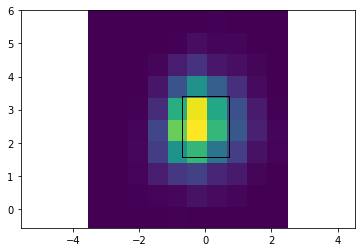

In [ ]:
import matplotlib.patches as patches
visualize_cols = model_df.drop('swing', axis = 1).columns
df_test = pd.DataFrame(data = x_test, columns = visualize_cols)
probables = pd.DataFrame(data = lgbm.predict_proba(x_test), columns = ['take_prob', 'swing_prob'])
df_test['swing_prob'] = probables['swing_prob']
top_sz = df['sz_top'].mean()
bot_sz = df['sz_bot'].mean()
sz = patches.Rectangle((-0.70833, bot_sz), width = 17/12, height = (top_sz - bot_sz), fill = False)
fig, ax = plt.subplots()
ax.add_patch(sz)
ax.axis('equal')
plt.hist2d(df_test['plate_x'], df_test['plate_z'])

In [ ]:
query_df.dtypes

prev_pitch_type     object
plate_x            float64
plate_z            float64
release_speed      float64
p_throws            object
pfx_x              float64
pfx_z              float64
vx0                float64
vy0                float64
vz0                float64
strikes              int64
balls                int64
swing                int64
dtype: object